<a href="https://colab.research.google.com/github/kritiyer/mydeeplabdemo/blob/master/AngioNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Upload model.py
# from google.colab import files
# files.upload()

from google.colab import drive

drive.mount('/content/gdrive')

%cd "/content/gdrive/My Drive/CritikAlNet demo/"

%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/CritikAlNet demo
5goodimages/     Combined_Network_V7.h5  model.py
best_images.zip  goodimages/             __pycache__/


In [2]:
#@title Python Imports

import os
from io import BytesIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import preprocess_input
from PIL import Image

print(tf.__version__)

2.2.0-rc3


Using TensorFlow backend.


In [3]:
#@title create Deeplab model and load weights

#create model instance

def create_model():
  from model import Deeplabv3
  from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, BatchNormalization
  from tensorflow.keras.models import Sequential, Model
  inputs = Input(shape=(512, 512, 1))

  activation_func = None
  X1 = Conv2D(1, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(inputs)
  X2 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X1)
  X3 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X2)
  X4 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X3)
  X5 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X4)
  X6 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation='tanh', 
              use_bias=False, data_format="channels_last")(X5)
  X7 = tf.keras.layers.concatenate([X6, X6, X6], axis=3)  

  unsharp_mask_model = Model(inputs=inputs, outputs=X7)
  deeplab_model = Deeplabv3(weights=None,backbone='xception',input_shape=(512,512,3), classes=2)

  combined_inputs = Input(shape=(512, 512, 1))
  unsharp_mask_img = unsharp_mask_model(combined_inputs)
  deeplab_img = deeplab_model(unsharp_mask_img)
  model = Model(combined_inputs,deeplab_img)

  return model

model = create_model()
#model.load_weights('Combined_Network_V7.h5')
model.load_weights("all_data_angio_L2_zoom_BS16.hdf5")
print('model loaded successfully!')

model loaded successfully!


# **Run on sample images**
Upload any sample image file and copy the image filename to open it in the next code block

In [4]:
#@title upload sample image zip folder
!unzip -uq best_images.zip -d ./
%ls

5goodimages/     Combined_Network_V7.h5  model.py
best_images.zip  goodimages/             __pycache__/


In [5]:
#@title Create data pipeline
def label_preprocess(image):
  x = image==1
  x = x.astype('float32')
  return x

data_gen_args = dict(preprocessing_function = preprocess_input);
label_gen_args = dict(preprocessing_function = label_preprocess);

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**label_gen_args)

seed = 0

batchsize = 1;

image_generator = image_datagen.flow_from_directory(
    './5goodimages/image',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    './5goodimages/label',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


In [6]:
#@title Generate segmentations of sample images

inference = model.predict(image_generator, batch_size=None, verbose=1, steps=10, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

10/10 [==============================] - 2s 161ms/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warni

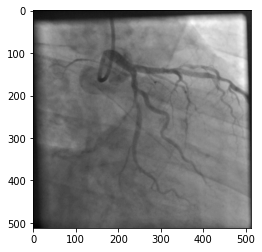

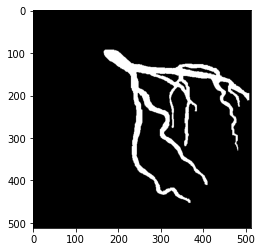

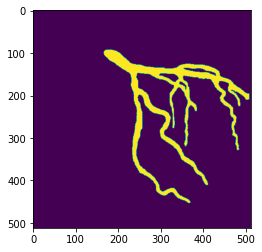

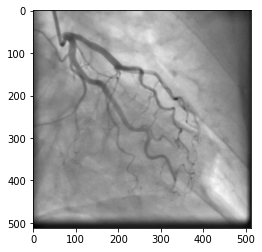

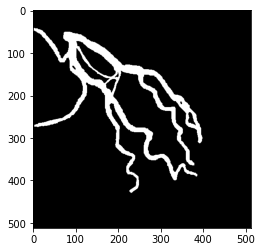

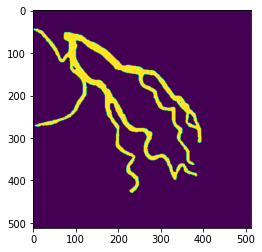

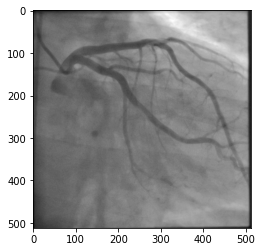

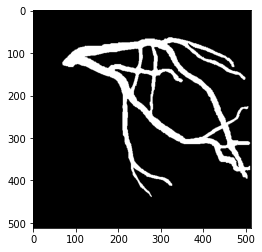

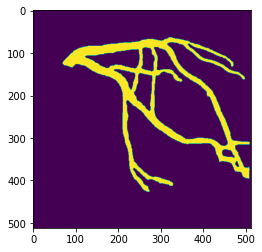

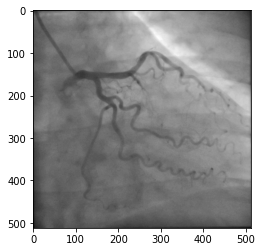

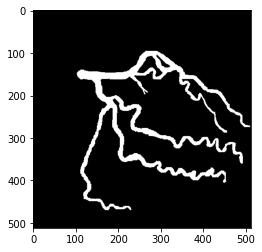

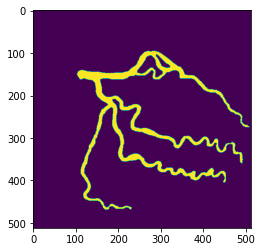

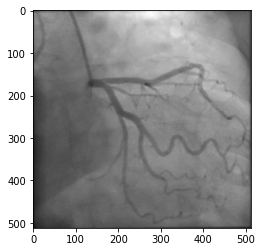

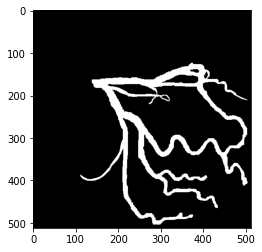

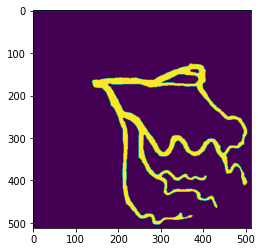

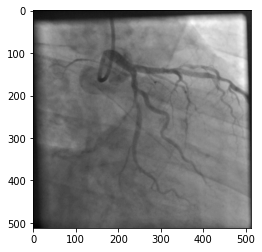

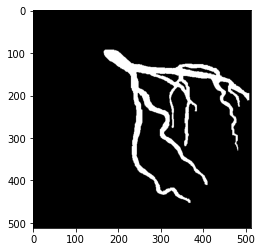

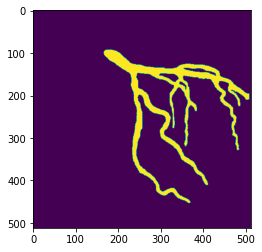

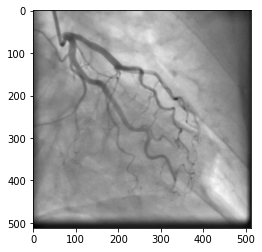

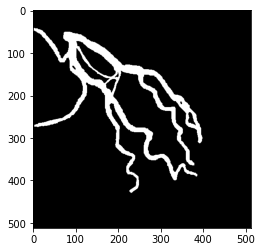

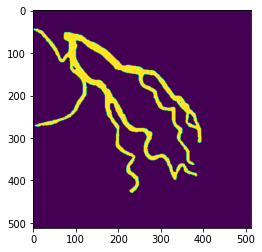

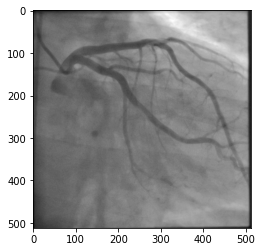

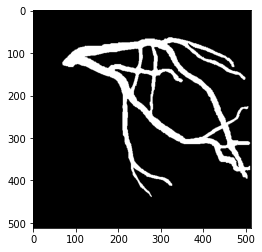

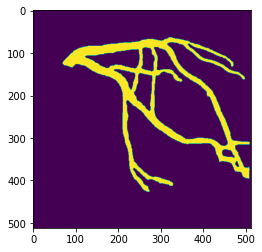

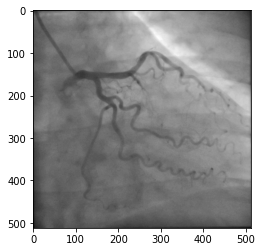

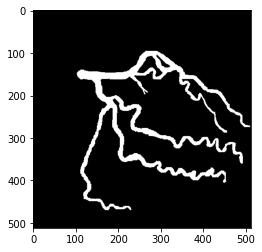

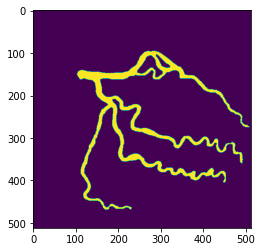

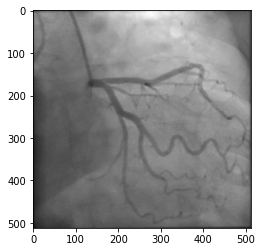

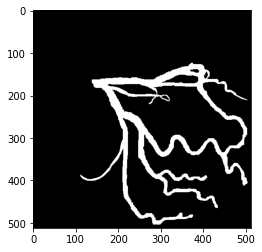

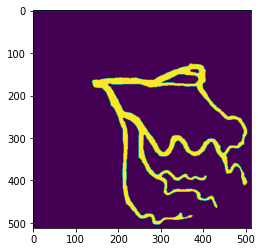

In [7]:
image_generator.reset()
mask_generator.reset()

for i in range(10):
  img = image_generator.next()
  label = mask_generator.next()

  plt.figure(); plt.imshow(np.squeeze(img), cmap="gray")
  plt.figure(); plt.imshow(np.squeeze(label), cmap="gray")
  full_sample = tf.nn.softmax(inference[i,:,:,:])

  pred = tf.argmax(full_sample, axis=-1)
  pred = pred.numpy() > 0
  plt.figure()
  plt.imshow(pred)